Importing Required Libraries 

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion

### Loading Data 

In [2]:
with open('data/pt1_data.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

In [4]:
gt.__dict__

{'do_diff': True,
 '_p_init': array([[ 8.34462935e-06,  9.08568545e-05, -5.00664425e+00],
        [ 7.85825614e-06,  9.12463729e-05, -5.00662613e+00],
        [ 7.38141944e-06,  9.16224817e-05, -5.00660801e+00],
        ...,
        [ 1.86048538e+02,  7.77716217e+01, -5.00547981e+00],
        [ 1.86111771e+02,  7.77564240e+01, -5.00548649e+00],
        [ 1.86174973e+02,  7.77412415e+01, -5.00549507e+00]]),
 '_r_init': array([[-4.10126808e-05, -6.78300823e-05,  1.06526437e-06],
        [-3.99474123e-05, -6.62803603e-05,  1.06526437e-06],
        [-3.88821479e-05, -6.48498500e-05,  1.06526437e-06],
        ...,
        [ 2.21818388e-05, -3.69322291e-03, -2.35822166e-01],
        [ 2.22517703e-05, -3.64327407e-03, -2.35821783e-01],
        [ 2.23312779e-05, -3.58641116e-03, -2.35821466e-01]]),
 '_v_init': array([None], dtype=object),
 '_w_init': array([None], dtype=object),
 '_a_init': array([None], dtype=object),
 '_alpha_init': array([None], dtype=object),
 '_t': array([ 2.055,  2.06 , 

In [5]:
lidar.data

array([[-1.21543380e+00, -9.50942168e-02, -4.99910491e-01],
       [ 1.51615773e-01, -3.22337937e-01,  1.98545449e-01],
       [-2.59387164e-01, -6.74227693e-01,  5.02131391e-01],
       ...,
       [ 1.88739634e+02,  6.00823985e+01,  5.59282323e+00],
       [ 1.89719938e+02,  6.04801328e+01,  5.65767381e+00],
       [ 1.91144238e+02,  5.93167056e+01,  5.82667079e+00]])

In [6]:
gt._v.shape, gt._a.shape

((8734, 3), (8734, 3))

In [7]:
imu_f.__dict__, imu_f.data.shape

({'data': array([[-0.01996148,  0.03136036,  9.78135591],
         [-0.01986699,  0.03743271,  9.79679338],
         [ 0.01269854, -0.02131687,  9.81265361],
         ...,
         [-1.32458701,  0.35196761,  9.73522034],
         [-0.47210374, -0.42987602,  9.76335312],
         [-1.31729961,  0.29819817,  9.76891354]]),
  't': array([ 2.055,  2.06 ,  2.065, ..., 56.64 , 56.645, 56.65 ])},
 (10918, 3))

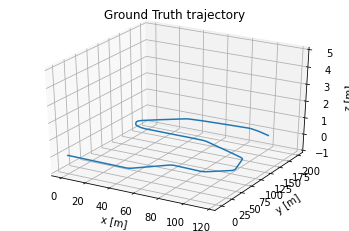

In [8]:
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

#### Remember that our LIDAR data is actually just a set of positions estimated from a separate scan-matching system, so we can insert it into our solver as another position measurement,just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our known extrinsic calibration rotation matrix C_li and translation vector t_i_li.

In [9]:
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])

In [10]:
# Incorrect calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.05).
# C_li = np.array([
#      [ 0.9975 , -0.04742,  0.05235],
#      [ 0.04992,  0.99763, -0.04742],
#      [-0.04998,  0.04992,  0.9975 ]
# ])

In [11]:
t_i_li = np.array([0.5, 0.1, 0.5])

In [12]:
# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

Important Constants in the simulation 

In [13]:
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.

var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01
var_lidar = 1.00

In [14]:
# We can also set up some constants that won't change for any iteration of our solver.

g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

Initial Values for our ES-EKF Solver


In [15]:
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

In [16]:
# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion(euler=gt.r[0]).to_numpy()
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

In [17]:
p_est

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [18]:
q_est

array([[ 9.99999999e-01, -2.05063223e-05, -3.39150521e-05,
         5.31936712e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

In [19]:
gt.p[1]

array([-4.86373210e-07,  3.89518391e-07,  1.81198120e-05])

## Measurement Update 

In [20]:
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make a function for it.

def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):
    """Performs a measurement update step for the ES-EKF.

    Args:
        sensor_var: Variance of the sensor.
        p_cov_check: Predicted covariance matrix.
        y_k: Measurement at timestep k.
        p_check: Predicted position at timestep k.
        v_check: Predicted velocity at timestep k.
        q_check: Predicted orientation quaternion at timestep k. """
    
    # Compute Kalman Gain
    r_cov = sensor_var * np.eye(3)  # measurement noise covariance
    s_k = h_jac @ p_cov_check @ h_jac.T + r_cov # innovation covariance
    k_k = p_cov_check @ h_jac.T @ np.linalg.inv(s_k)  # Kalman gain

    # Compute error state
    y_tilde = y_k - p_check  # measurement residual
    delta_x = k_k @ y_tilde  # error state - x_error

    # Correct predicted state
    p_hat = p_check + delta_x[0:3]
    v_hat = v_check + delta_x[3:6]
    delta_theta = delta_x[6:9]
    # q_hat = Quaternion(euler=delta_theta) * Quaternion(array=q_check)
    q_hat = Quaternion(euler=delta_theta).quat_mult_left(q_check)

    # Compute corrected covariance
    i_k = np.eye(9)
    p_cov_hat = (i_k - k_k @ h_jac) @ p_cov_check

    return p_hat, v_hat, q_hat, p_cov_hat
    

#### ??Quaternion

In [21]:
Quaternion(*q_est[0]).to_numpy()

array([ 9.99999999e-01, -2.05063223e-05, -3.39150521e-05,  5.31936712e-07])

In [22]:
Quaternion(*q_est[0]).to_mat()

array([[ 9.99999998e-01, -1.06248248e-06, -6.78301259e-05],
       [ 1.06526437e-06,  9.99999999e-01,  4.10126085e-05],
       [ 6.78300822e-05, -4.10126807e-05,  9.99999997e-01]])

# Main Filter Loop 

In [23]:
# Now that everything is set up, we can start taking in the sensor data and creating estimates for our state in a loop.
# for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
#     delta_t = imu_f.t[k] - imu_f.t[k - 1]

#     # 1. Update state with IMU inputs
#     f_k = imu_f.data[k - 1]
#     w_k = imu_w.data[k - 1]
#     # a. Compute predicted state
#     q_prev = Quaternion(*q_est[k - 1])
#     C_ns = q_prev.to_mat()
#     C_ns_d_f_km = np.dot(C_ns, imu_f.data[k-1])

#     p_est[k] = p_est[k - 1] + v_est[k - 1] * delta_t + 0.5 * (C_ns @ f_k + g) * delta_t**2
#     v_est[k] = v_est[k - 1] + (C_ns @ f_k + g) * delta_t
#     delta_theta = w_k * delta_t
#     q_fr_w = Quaternion(axis_angle=imu_w.data[k-1] * delta_t)
#     q_est[k] = q_fr_w.quat_mult_right(q_est[k-1])
    
#     # 1.1 Linearize the motion model and compute Jacobians
#     f_ja_km = np.identity(9)
#     f_ja_km[0:3, 3:6] = np.identity(3) * delta_t
#     f_ja_km[3:6, 6:9] = -C_ns @ skew_symmetric(f_k) * delta_t

#     # 2. Propagate uncertainty
#     q_cov_km = np.identity(6)
#     q_cov_km[0:3,0:3] *=  delta_t**2 * np.eye(3) * var_imu_f
#     q_cov_km[3:6, 3:6] *= delta_t**2 * np.eye(3) * var_imu_w
#     p_cov_check = f_ja_km @ p_cov[k - 1] @ f_ja_km.T + l_jac @ q_cov_km @ l_jac.T

#     # 3. Check availability of GNSS and LIDAR measurements
#     if gnss_i < gnss.data.shape[0] and imu_f.t[k] == gnss.t[gnss_i]:
#         p_est[k], v_est[k], q_est[k], p_cov[k] = \
#             measurement_update(var_gnss, p_cov[k], gnss.data[gnss_i].T, p_est[k], v_est[k], q_est[k])
#         gnss_i += 1
        
#     if lidar_i < lidar.t.shape[0] and lidar.t[lidar_i] == imu_f.t[k-1]:
#         p_est[k], v_est[k], q_est[k], p_cov[k] = \
#             measurement_update(var_lidar, p_cov[k], lidar.data[lidar_i].T, p_est[k], v_est[k], q_est[k])
#         lidar_i += 1

  

In [24]:
# Now that everything is set up, we can start taking in the sensor data and creating estimates for our state in a loop. 
for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt
    delta_t = imu_f.t[k] - imu_f.t[k - 1]

    # 1. Update state with IMU inputs
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    
    C_ns_d_f_km = np.dot(C_ns, imu_f.data[k-1])
    
    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + (delta_t**2) / 2 * (C_ns_d_f_km + g)
    v_est[k] = v_est[k-1] + delta_t * (C_ns_d_f_km + g)
    q_fr_w = Quaternion(axis_angle=imu_w.data[k-1] * delta_t)
    q_est[k] = q_fr_w.quat_mult_right(q_est[k-1])
    
    # 1.1 Linearize the motion model and compute Jacobians
    f_ja_km = np.identity(9)
    f_ja_km[0:3, 3:6] = np.identity(3) * delta_t
    f_ja_km[3:6, 6:9] = -skew_symmetric(C_ns_d_f_km) * delta_t
    
    # 2. Propagate uncertainty
    q_cov_km = np.identity(6)
    q_cov_km[0:3,0:3] *=  delta_t**2 * np.eye(3) * var_imu_f
    q_cov_km[3:6, 3:6] *= delta_t**2 * np.eye(3) * var_imu_w
    p_cov[k] = f_ja_km.dot(p_cov[k-1]).dot(f_ja_km.T) + l_jac.dot(q_cov_km).dot(l_jac.T)
    
    # 3. Check availability of GNSS and LIDAR measurements
    if gnss_i < gnss.data.shape[0] and imu_f.t[k] == gnss.t[gnss_i]:
        p_est[k], v_est[k], q_est[k], p_cov[k] = \
            measurement_update(var_gnss, p_cov[k], gnss.data[gnss_i].T, p_est[k], v_est[k], q_est[k])
        gnss_i += 1
        
    if lidar_i < lidar.t.shape[0] and lidar.t[lidar_i] == imu_f.t[k-1]:
        p_est[k], v_est[k], q_est[k], p_cov[k] = \
            measurement_update(var_lidar, p_cov[k], lidar.data[lidar_i].T, p_est[k], v_est[k], q_est[k])
        lidar_i += 1

In [25]:
np.zeros(3)

array([0., 0., 0.])

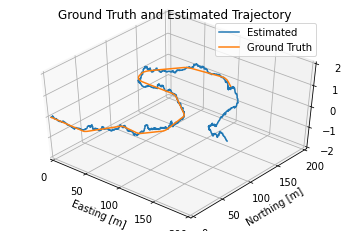

In [26]:
# 6. Results and Analysis 

# Now that we have state estimates for all of our sensor data, let's plot the results. This plot will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating your estimated poses from the part of the trajectory where you don't have ground truth!

est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


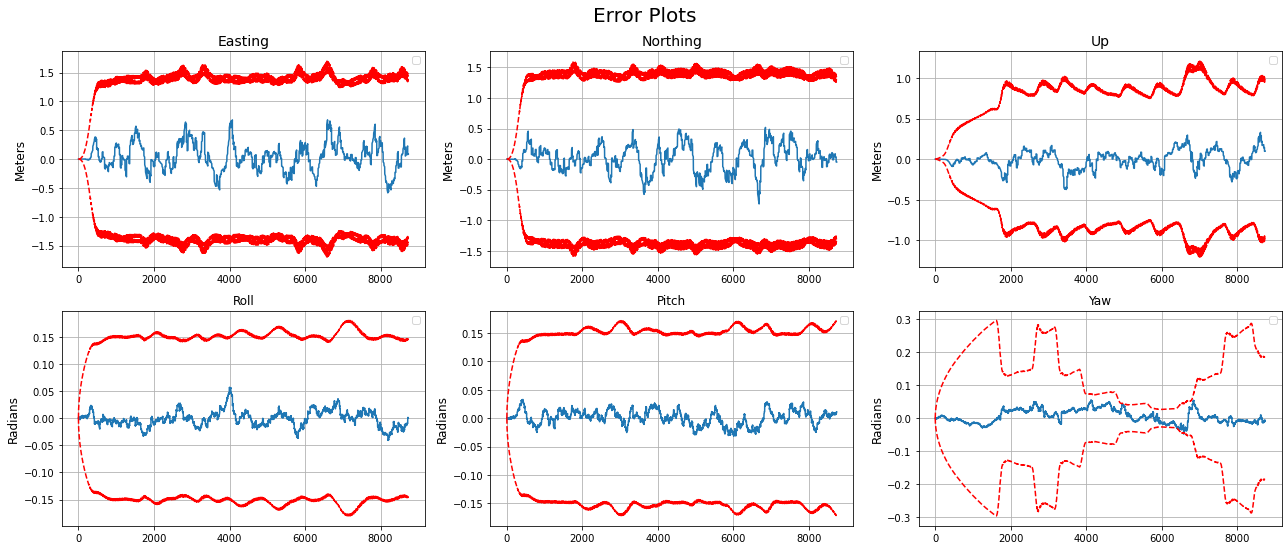

In [27]:
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).

error_fig, ax = plt.subplots(2, 3,figsize=(18, 8))
error_fig.suptitle('Error Plots', fontsize=20)
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i], fontsize=14)
    ax[0, i].set_ylabel('Meters', fontsize=12)
    ax[0, i].grid(True)
    ax[0, i].legend(fontsize=10)

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
    ax[1, i].set_ylabel('Radians', fontsize=12)
    ax[1, i].grid(True)
    ax[1, i].legend(fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
plt.show()

In [28]:
#7. Submission 

# Now we can prepare your results for submission to the Coursera platform. Uncomment the corresponding lines to prepare a file that will save your position estimates in a format
# that corresponds to what we're expecting on Coursera.


# Pt. 1 submission
p1_indices = [9000, 9400, 9800, 10200, 10600]
p1_str = ''
for val in p1_indices:
    for i in range(3):
        p1_str += '%.3f ' % (p_est[val, i])
with open('pt1_submission.txt', 'w') as file:
    file.write(p1_str)

# Pt. 2 submission
# p2_indices = [9000, 9400, 9800, 10200, 10600]
# p2_str = ''
# for val in p2_indices:
#     for i in range(3):
#         p2_str += '%.3f ' % (p_est[val, i])
# with open('pt2_submission.txt', 'w') as file:
#     file.write(p2_str)

# Pt. 3 submission
# p3_indices = [6800, 7600, 8400, 9200, 10000]
# p3_str = ''
# for val in p3_indices:
#     for i in range(3):
#         p3_str += '%.3f ' % (p_est[val, i])
# with open('pt3_submission.txt', 'w') as file:
#     file.write(p3_str)